In [1]:
import tensorflow as tf

print(tf.__version__)

2.4.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

import matplotlib.pyplot as plt
import cv2
from google.colab import drive
# Accessing My Google Drive
#drive.mount('/content/drive')
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense,GlobalAveragePooling2D,Convolution2D
from keras.applications import DenseNet121
from keras.layers import GaussianNoise
from keras.layers import Dropout
from keras.layers import BatchNormalization
from glob import glob
import numpy as np
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.layers import Activation
from keras.layers import concatenate
from keras.layers import UpSampling2D
from keras import Model

import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

In [4]:
training_path = 'drive/My Drive/ISIC_2019_Training_Input'
validation_path = 'drive/My Drive/groundtruth_val.csv'

Train_path =  'drive/My Drive/groundtruth_train.csv'
#train_data = Train_df['image']



train_data = pd.read_csv(Train_path, encoding='latin1', dtype={"image": str, "MEL": int, "NV": int, "BCC": int, "AK": int,"BKL": int, "": int, "DF": int, "VASC": int,"SCC": int, "UNK": int})
train_data['image'] =train_data['image']+'.jpg'
labels = np.argmax(np.array(train_data.iloc[:,1:10]), axis=1)
images = np.asarray(train_data.iloc[:, 0])
classes = list(train_data.columns.values[1:10])

validation_data = pd.read_csv(validation_path, encoding='latin1', dtype={"image": str, "MEL": int, "NV": int, "BCC": int, "AK": int,"BKL": int, "": int, "DF": int, "VASC": int,"SCC": int, "UNK": int})
validation_data['image'] =validation_data['image']+'.jpg'
val_labels = np.argmax(np.array(validation_data.iloc[:,1:10]), axis=1)
val_images = np.asarray(validation_data.iloc[:, 0])
val_classes = list(validation_data.columns.values[1:10])

In [5]:
def Residual_block(input, size):
    conv1 = Conv2D(size, 1, activation = 'relu', padding = 'same')(input)
    batch1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(batch1)
    conv2 = Conv2D(size, 1, activation = 'relu', padding = 'same')(act1)
    batch2 = BatchNormalization()(conv2)
    merge = Add()([batch2, input])
    act2 = Activation('relu')(merge)
    out = Conv2D(size, 1, activation = 'relu', padding = 'same')(act2)

    return out

In [6]:
def uresnet50(pretrained_weights = None,input_size = (256,256,3)):
    
    inputs = Input(input_size)
    conv1 = Conv2D(64, 7, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', strides= (2,2))(inputs)
    pool1 = MaxPooling2D(pool_size=(3, 3), strides= 2, padding= 'same')(conv1)
    print(pool1.shape)
    
    conv1 = Conv2D(64, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = Conv2D(256, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    # pool2 = MaxPooling2D(pool_size=(3, 3), strides= 2, padding= 'same')(conv1)

    # conv1 = Conv2D(64, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    # conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    # conv1 = Conv2D(256, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

    # conv1 = Conv2D(64, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    # conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    # conv1 = Conv2D(256, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

    res1 = Residual_block(conv1, 256)
    
    conv2 = Conv2D(128, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(res1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = Conv2D(512, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool3 = MaxPooling2D(pool_size=(3, 3), strides= 2, padding= 'same')(conv2)
    print(pool3.shape)

    # conv2 = Conv2D(128, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    # conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    # conv2 = Conv2D(512, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)

    # conv2 = Conv2D(128, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    # conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    # conv2 = Conv2D(512, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)

    # conv2 = Conv2D(128, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    # conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    # conv2 = Conv2D(512, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)

    res2 = Residual_block(pool3, 512)
    
    conv3 = Conv2D(256, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(res2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = Conv2D(1024, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool4 = MaxPooling2D(pool_size=(3, 3), strides= 2, padding= 'same')(conv3)
    print(pool4.shape)

    # conv3 = Conv2D(256, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # conv3 = Conv2D(1024, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

    # conv3 = Conv2D(256, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # conv3 = Conv2D(1024, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

    # conv3 = Conv2D(256, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # conv3 = Conv2D(1024, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

    # conv3 = Conv2D(256, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # conv3 = Conv2D(1024, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

    # conv3 = Conv2D(256, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # conv3 = Conv2D(1024, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

    res3 = Residual_block(pool4, 1024)
    
    conv4 = Conv2D(512, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(res3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = Conv2D(2048, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool5 = MaxPooling2D(pool_size=(3, 3), strides= 2, padding= 'same')(conv4)
    print(pool5.shape)

    # conv4 = Conv2D(512, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    # conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    # conv4 = Conv2D(2048, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)

    # conv4 = Conv2D(512, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    # conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    # conv4 = Conv2D(2048, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)

    res4 = Residual_block(pool5, 2048)
    
    up1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(res4))
    merge6 = concatenate([res3,up1], axis = 3)
    dconv2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

    up2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(dconv2))
    merge7 = concatenate([res2,up2], axis = 3)
    dconv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

    up3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(dconv4))
    merge8 = concatenate([res1,up3], axis = 3)
    dconv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

    upsamp = UpSampling2D(size = (2,2))(dconv6)
    up4 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(upsamp)
    print(upsamp.shape)
    merge9 = concatenate([pool1,dconv6], axis = 3)
    dconv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)

    up5 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(dconv8))
    dconv10 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up5)

    out = Conv2D(1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(dconv10)

    flatten = Flatten()(out)
    dense1 = Dense(1024, activation='relu')(flatten)
    dense2 = Dense(512, activation='relu')(dense1)
    batch1 = BatchNormalization()(dense2)
    drop1 = Dropout(0.5)(batch1)

    preds = Dense(9,activation='softmax')(drop1)

    model = Model(inputs = inputs, outputs = preds)

    model.compile(optimizer = Adam(lr = 1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

y = uresnet50()


(None, 64, 64, 64)
(None, 32, 32, 512)
(None, 16, 16, 1024)
(None, 8, 8, 2048)
(None, 128, 128, 64)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   4160        max_pooling2d[0][0]         

In [7]:

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_dataframe(train_data,
                                                 directory= training_path,
                                                 x_col= 'image',
                                                 y_col= list(classes),


                                                 target_size =(256,256),
                                                 batch_size = 16,
                                                 class_mode ='raw',
                                                 validate_filenames=False)
test_set = test_datagen.flow_from_dataframe(validation_data,
                                                  directory= training_path,
                                                  x_col= 'image',
                                                  y_col= list(val_classes),


                                                  target_size =(256,256),
                                                  batch_size = 16,
                                                  class_mode ='raw',
                                                  validate_filenames=False)

y.fit(training_set, validation_data = test_set, steps_per_epoch = len(training_set)/17,validation_steps =len(test_set)/14, epochs = 15)

y.save("uresnet50trial.h5")

Found 22797 non-validated image filenames.
Found 2534 non-validated image filenames.
Epoch 1/15
83/83 [==============================] - 2394s 28s/step - loss: 2.3039 - accuracy: 0.2609 - val_loss: 1.5736 - val_accuracy: 0.4896
Epoch 2/15
83/83 [==============================] - 2328s 28s/step - loss: 1.5759 - accuracy: 0.4544 - val_loss: 1.4484 - val_accuracy: 0.4792
Epoch 3/15
83/83 [==============================] - 2325s 28s/step - loss: 1.4387 - accuracy: 0.4839 - val_loss: 1.6725 - val_accuracy: 0.1719
Epoch 4/15
83/83 [==============================] - 2279s 27s/step - loss: 1.3069 - accuracy: 0.5386 - val_loss: 1.8030 - val_accuracy: 0.2083
Epoch 5/15
83/83 [==============================] - 2279s 27s/step - loss: 1.4401 - accuracy: 0.4990 - val_loss: 2.4797 - val_accuracy: 0.4948
Epoch 6/15
83/83 [==============================] - 2262s 27s/step - loss: 1.3589 - accuracy: 0.5083 - val_loss: 2.7235 - val_accuracy: 0.2656
Epoch 7/15
83/83 [==============================] - 2247s

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          15 non-null     float64
 1   accuracy      15 non-null     float64
 2   val_loss      15 non-null     float64
 3   val_accuracy  15 non-null     float64
dtypes: float64(4)
memory usage: 608.0 bytes


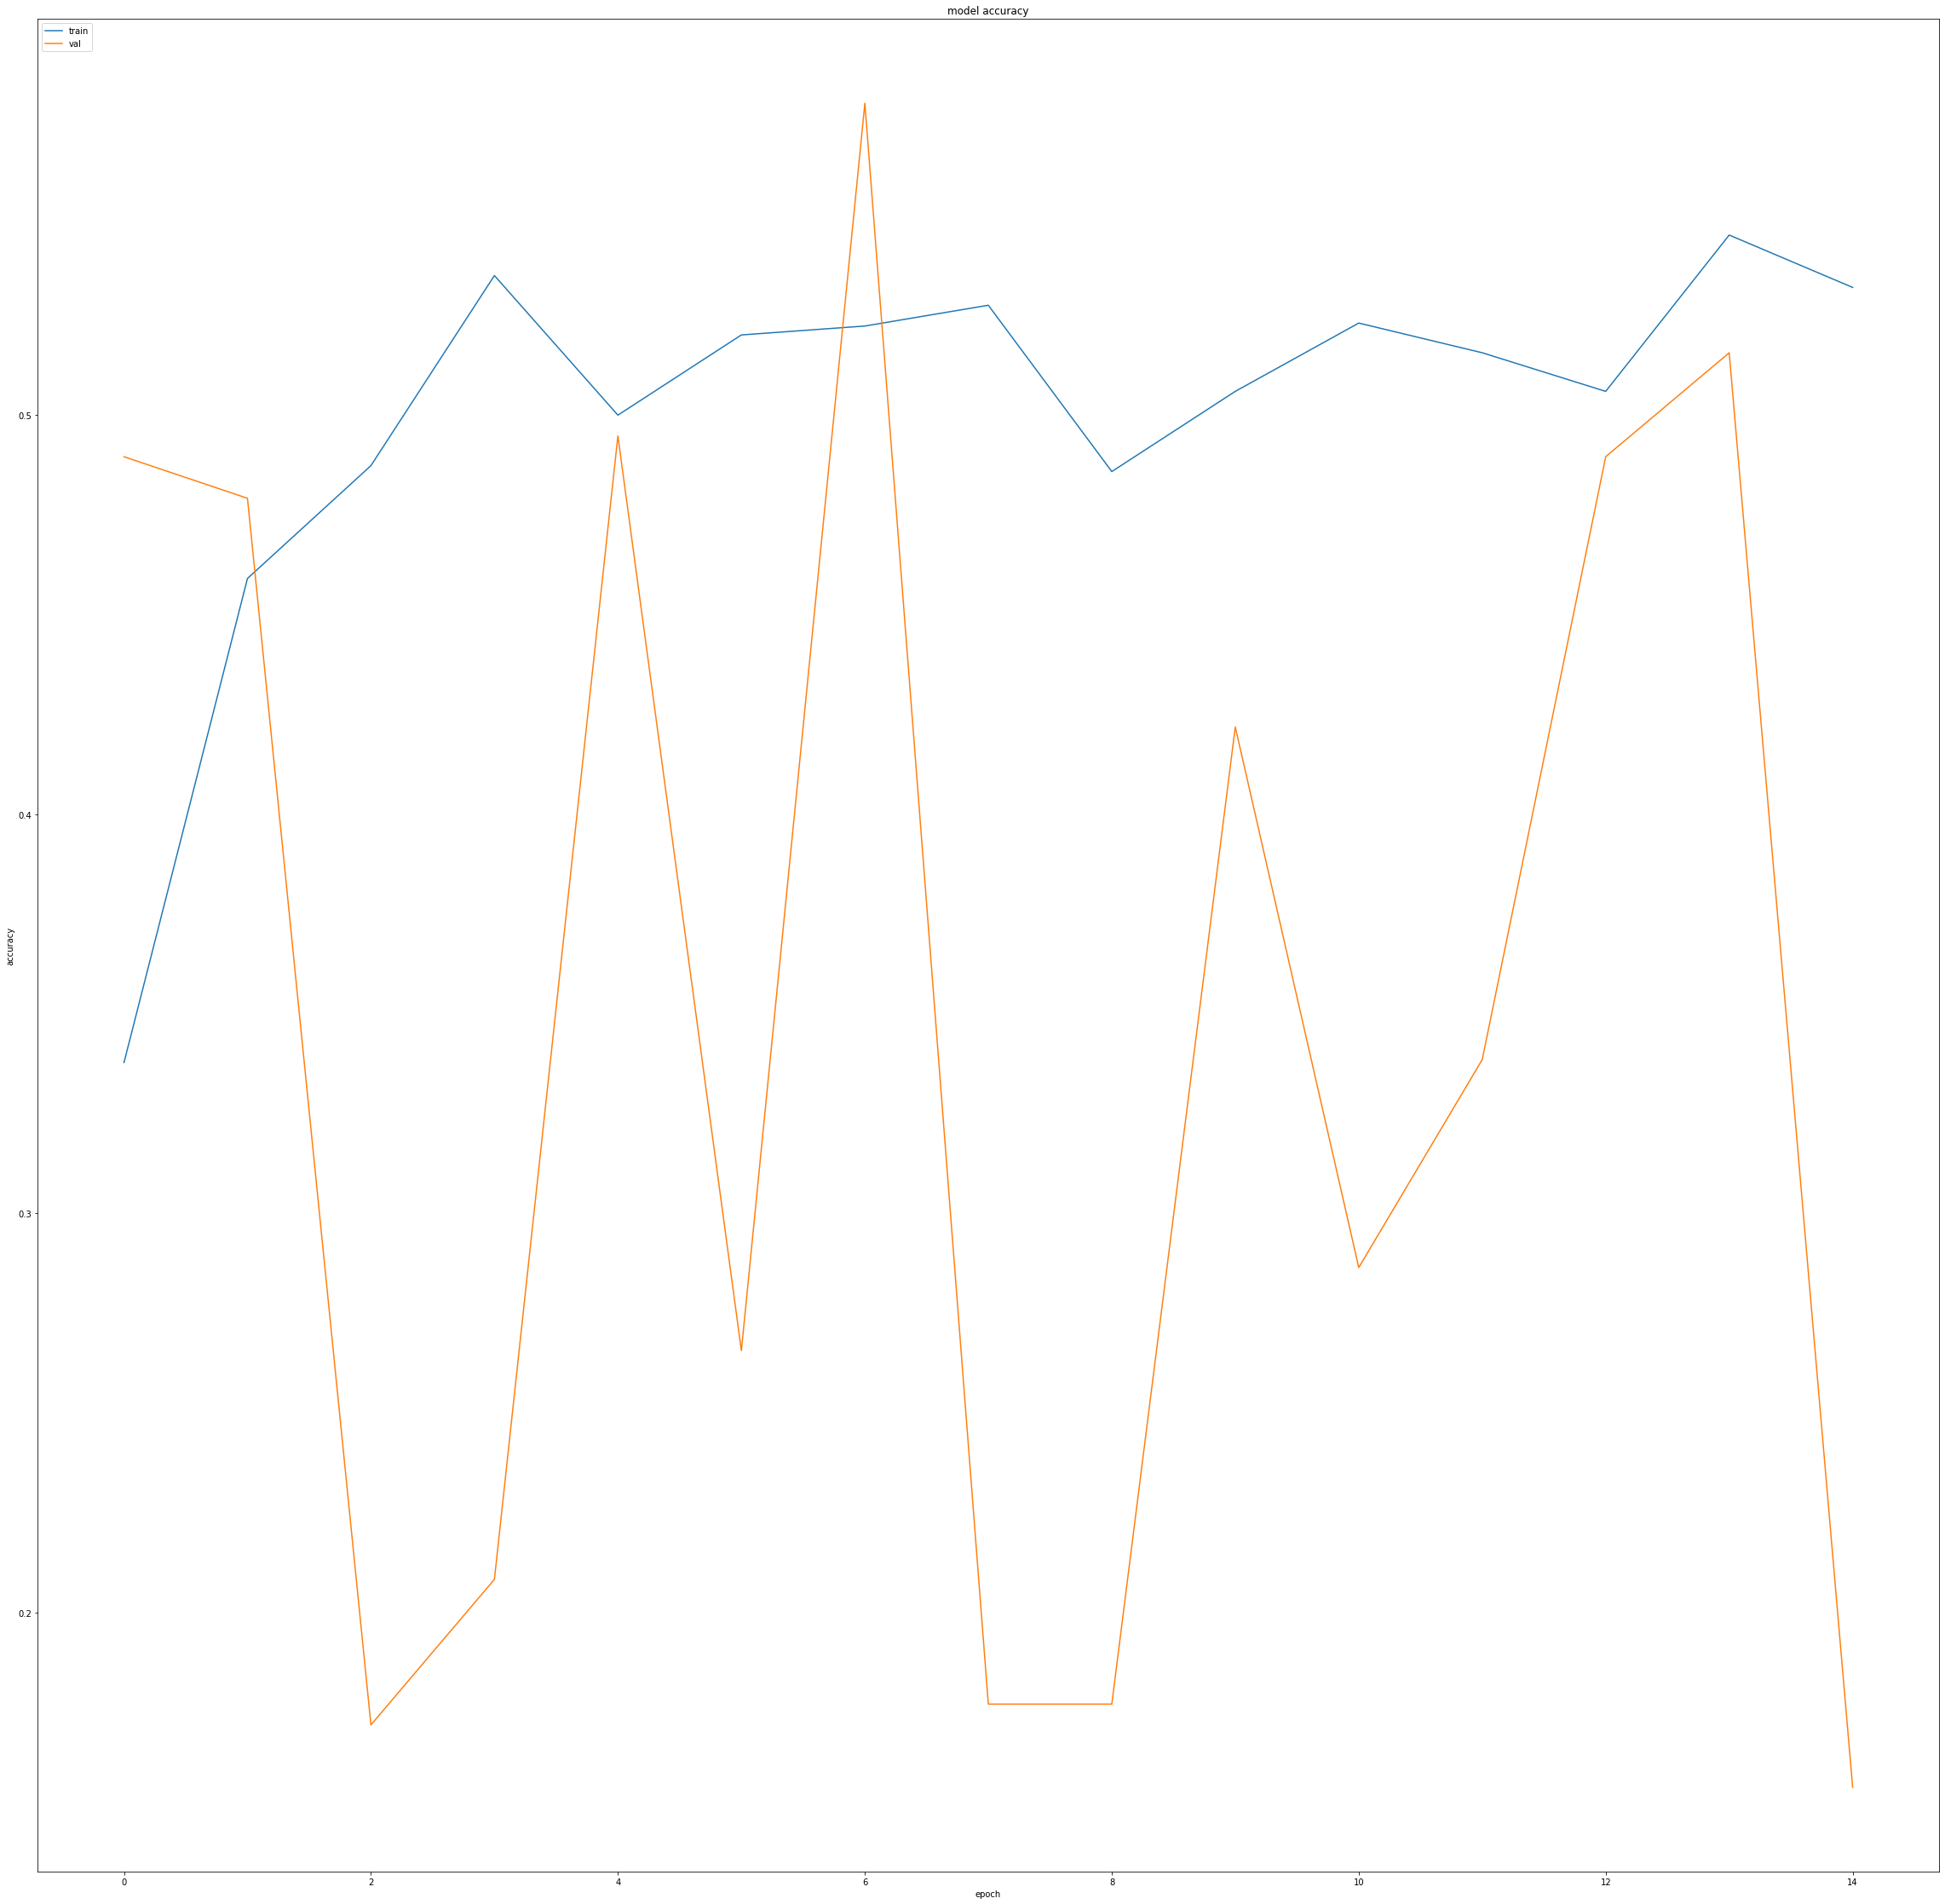

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))

loses = pd.DataFrame(y.history.history)
# loses.plot()
loses.info()

plt.plot(y.history.history['accuracy'])
plt.plot(y.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

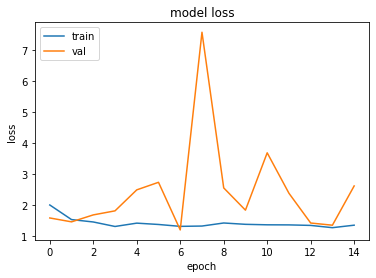

In [10]:

plt.plot(y.history.history['loss'])
plt.plot(y.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()